In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats

In [161]:
df = pd.read_csv('data/clean_nonull.csv')

df = pd.concat([
    df.drop(columns=['VKORC1_SNP', 'CYP2C9 consensus']),
    pd.get_dummies(df['VKORC1_SNP'], prefix='VKORC1_SNP', drop_first=True),
    pd.get_dummies(df['CYP2C9 consensus'], prefix='CYP2C9', drop_first=True)
], axis=1)

df['constant'] = 1

df['label'] = df['correct_dosage'].map({'low': 0, 'medium': 1, 'high': 2})

In [163]:
def clinical_baseline(x):
    x = np.squeeze(x)
    
    sqrt_weekly_dose = 4.0376 - 0.2546 * x[0] + 0.0118 * x[1] \
    + 0.0134 * x[2] - 0.6752 * x[3] \
    + 0.4060 * x[4] + 0.0443 * x[5] \
    + 1.2799 * x[6] - 0.5695 * x[7]
    
    
    cutoffs = np.array([0, np.sqrt(21), np.sqrt(49)])
    
    return np.where(cutoffs < sqrt_weekly_dose)[0].max()


# choose the closest integer
def find_closest(x):
    if x < 0.5:  # closer to 0 than 1 or 2
        return 0
    elif x < 1.5: # closer to 1 than 0 or 2
        return 1
    return 2

In [164]:
np.random.seed(1)

S = 20

perfs = []
for s in tqdm(range(S)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]

    # randomly sample the first arm, and set the corresponding reward
    chosen_arms = [np.random.randint(3)]
    sup_chosen_arms = [chosen_arms[0]]

    # set up the b vectors
    b = {
        0: np.zeros(X.shape[1]).reshape(X.shape[1], 1),
        1: np.zeros(X.shape[1]).reshape(X.shape[1], 1),
        2: np.zeros(X.shape[1]).reshape(X.shape[1], 1)
    }

    # set up the A matrices
    A = {
        0: np.identity(X.shape[1]),
        1: np.identity(X.shape[1]),
        2: np.identity(X.shape[1])
    }

    alpha = 0.2

    for i in range(1, X.shape[0]):  # choose a patient
        x_t = X[i].reshape(X.shape[1], 1).copy()

        theta = []
        p = []
        for a in range(3):
            A_inv = np.linalg.inv(A[a])
            theta.append(A_inv @ b[a])
            p.append(theta[a].T @ x_t + alpha * np.sqrt(x_t.T @ A_inv @ x_t)[0])

        pred_a = int(np.argmax(p))

        r_t = 0 if y[i] == pred_a else -1

        # update the matrices
        A[pred_a] += x_t @ x_t.T
        b[pred_a] += r_t * x_t
        
        chosen_arms.append(pred_a)
        
        # now do the supervised comparison
        cumul_X = X[:i].copy()
        cumul_y = y[:i].copy()
        
        sup_pred_a = find_closest(np.dot(np.squeeze(x_t), np.linalg.pinv(cumul_X) @ cumul_y))
        sup_chosen_arms.append(sup_pred_a)
        
        
    perf = pd.DataFrame({
        "run": s,
        "predicted_arm": chosen_arms,
        "supervised_predicted_arm": sup_chosen_arms,
        "true_arm": y,
        "clincal_baseline_predicted_arm": [clinical_baseline(x) for x in X]
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_supervised_accuracy'] = (
        perf['supervised_predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_clinical_baseline_accuracy'] = (
        perf['clincal_baseline_predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * np.where(
        perf['predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perf['cumulative_supervised_regret'] = -1 * np.where(
        perf['supervised_predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perf['cumulative_clinical_baseline_regret'] = -1 * np.where(
        perf['clincal_baseline_predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

linucb_performances = pd.concat(perfs)
linucb_performances['t'] = linucb_performances.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:49<00:00, 11.46s/it]


In [167]:
X.shape

(4386, 23)

<AxesSubplot:xlabel='t'>

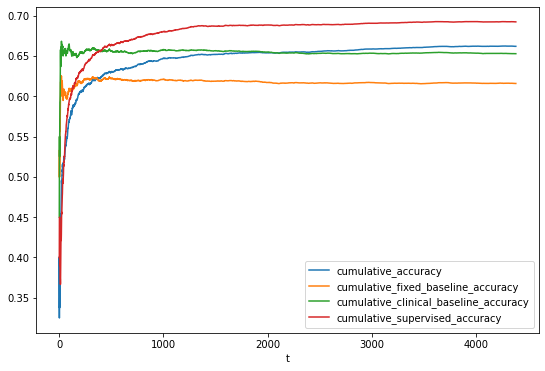

In [165]:
linucb_grouped = linucb_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy', 'cumulative_supervised_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret', 'cumulative_supervised_regret'
]].mean()    

linucb_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy',
    'cumulative_clinical_baseline_accuracy',
    'cumulative_supervised_accuracy'
]].plot(figsize=(9,6))

<AxesSubplot:xlabel='t'>

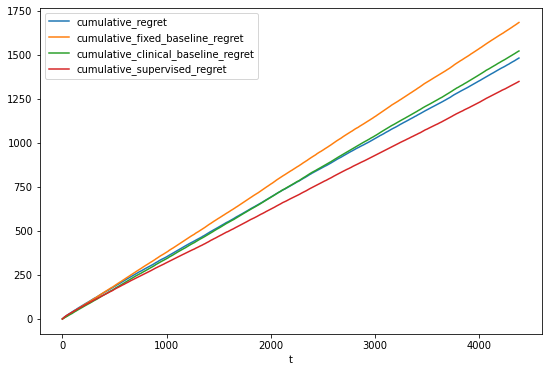

In [168]:
linucb_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret',
    'cumulative_clinical_baseline_regret',
    'cumulative_supervised_regret'
]].plot(figsize=(9,6))

In [169]:
linucb_grouped.reset_index().to_csv('linucb_results_supervised.csv', index=False)

In [170]:
linucb_grouped_std = linucb_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy', 'cumulative_supervised_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret', 'cumulative_supervised_regret'
]].std() 

linucb_grouped_std.reset_index().to_csv('linucb_results_supervised_std.csv', index=False)